In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()

Saving Customers.csv to Customers.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Products.csv to Products.csv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving Transactions.csv to Transactions.csv


In [6]:
customers_df = pd.read_csv('/content/Customers.csv')
products_df = pd.read_csv('/content/Products.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')


In [7]:
print(customers_df.head())
print(products_df.head())
print(transactions_df.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [11]:
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')


In [13]:
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'], errors='coerce')


In [14]:
customer_features = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    unique_products=('ProductID', 'nunique'),
    total_quantity=('Quantity', 'sum'),
    recency=('TransactionDate', lambda x: (x.max() - x.min()).days)  # Difference between the max and min date
).reset_index()


In [15]:
print(customer_features.head())


  CustomerID  total_spent  unique_products  total_quantity  recency
0      C0001      3354.52                5              12      288
1      C0002      1862.74                4              10      278
2      C0003      2725.38                4              14      188
3      C0004      5354.88                8              23      299
4      C0005      2034.24                3               7      233


In [16]:
# Convert TransactionDate to datetime
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'], errors='coerce')

# Aggregate customer-level features
customer_features = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    unique_products=('ProductID', 'nunique'),
    total_quantity=('Quantity', 'sum'),
    recency=('TransactionDate', lambda x: (x.max() - x.min()).days)
).reset_index()

# Check the first few rows
print(customer_features.head())


  CustomerID  total_spent  unique_products  total_quantity  recency
0      C0001      3354.52                5              12      288
1      C0002      1862.74                4              10      278
2      C0003      2725.38                4              14      188
3      C0004      5354.88                8              23      299
4      C0005      2034.24                3               7      233


In [17]:
final_df = pd.merge(customer_features, customers_df[['CustomerID', 'Region']], on='CustomerID', how='inner')


In [19]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df[['total_spent', 'unique_products', 'total_quantity', 'recency']])


In [20]:
# Using KMeans for clustering
kmeans = KMeans(n_clusters=5, random_state=42)
final_df['cluster'] = kmeans.fit_predict(scaled_data)

# Display cluster centroids
print("Cluster Centers:")
print(kmeans.cluster_centers_)


Cluster Centers:
[[ 2.05642363  1.81770803  2.17455445  0.40437903]
 [-1.35241246 -1.52360331 -1.38886021 -2.12992392]
 [ 0.06548461  0.27093041  0.09006901  0.23806572]
 [-0.69105751 -0.72061074 -0.73322155 -0.0066268 ]
 [ 1.10949346  0.92164233  1.11135661  0.68655298]]


In [21]:
db_index = davies_bouldin_score(scaled_data, final_df['cluster'])
print(f"DB Index: {db_index}")


DB Index: 1.114265537156305


In [22]:
silhouette = silhouette_score(scaled_data, final_df['cluster'])
print(f"Silhouette Score: {silhouette}")


Silhouette Score: 0.29375823852053506


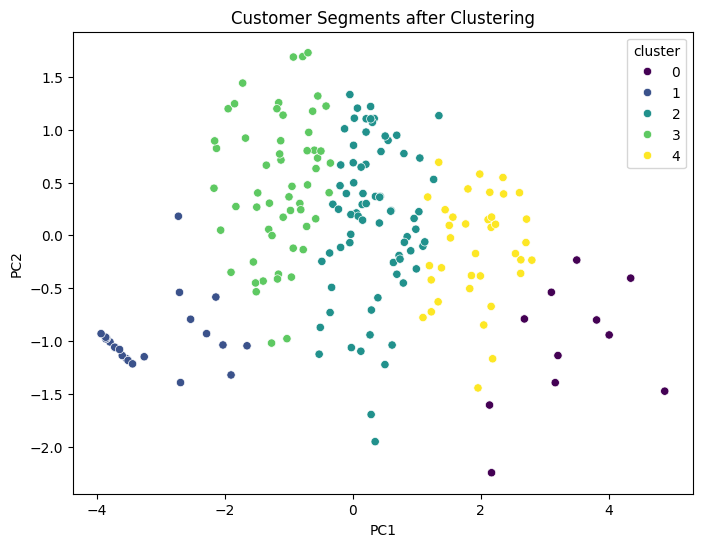

In [23]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = final_df['cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
plt.title("Customer Segments after Clustering")
plt.show()


In [24]:
# Show the cluster centroids
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=['total_spent', 'unique_products', 'total_quantity', 'recency'])
print(centroids_df)


   total_spent  unique_products  total_quantity   recency
0     2.056424         1.817708        2.174554  0.404379
1    -1.352412        -1.523603       -1.388860 -2.129924
2     0.065485         0.270930        0.090069  0.238066
3    -0.691058        -0.720611       -0.733222 -0.006627
4     1.109493         0.921642        1.111357  0.686553


In [25]:
cluster_counts = final_df['cluster'].value_counts()
print(cluster_counts)


cluster
2    73
3    56
4    37
1    22
0    11
Name: count, dtype: int64


In [26]:
# Group by clusters and calculate the mean for each feature
cluster_profile = final_df.groupby('cluster').agg(
    total_spent_avg=('total_spent', 'mean'),
    unique_products_avg=('unique_products', 'mean'),
    total_quantity_avg=('total_quantity', 'mean'),
    recency_avg=('recency', 'mean')
).reset_index()

print(cluster_profile)


   cluster  total_spent_avg  unique_products_avg  total_quantity_avg  \
0        0      7226.595455             8.727273           26.090909   
1        1       995.013182             1.681818            4.227273   
2        2      3587.024658             5.465753           13.301370   
3        3      2204.014643             3.375000            8.250000   
4        4      5495.543243             6.837838           19.567568   

   recency_avg  
0   261.545455  
1    29.045455  
2   246.287671  
3   223.839286  
4   287.432432  


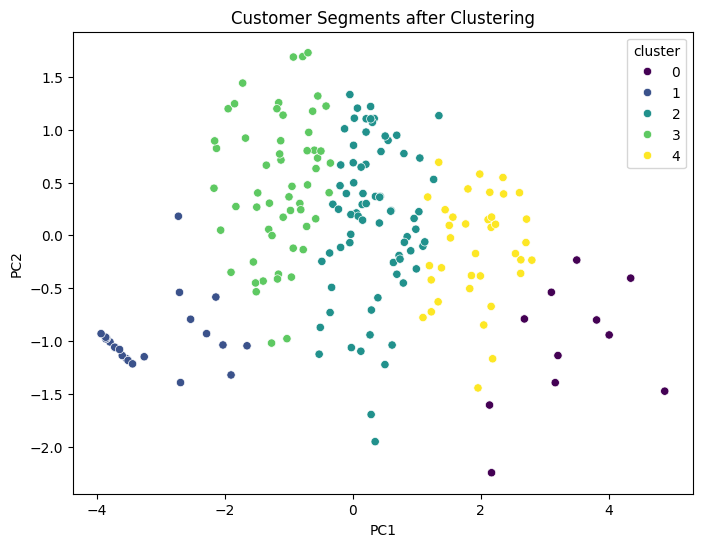

In [27]:
# Example of PCA plot code
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
plt.title("Customer Segments after Clustering")
plt.show()


In [35]:
!pip install reportlab

In [36]:
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import letter

def generate_clustering_report(file_name, num_clusters, db_index, silhouette_score):
    # Set up the document and styles
    doc = SimpleDocTemplate(file_name, pagesize=letter)
    story = []
    styles = getSampleStyleSheet()

    # Title
    title = Paragraph("Customer Segmentation Clustering Report", styles['Title'])
    story.append(title)
    story.append(Spacer(1, 12))

    # Objective section
    objective = Paragraph(
        """<b>1. Objective</b><br/>
        The objective of this analysis is to segment customers into distinct groups based on their purchasing behavior and demographic characteristics using unsupervised machine learning techniques. This helps in identifying customer groups and targeting them more effectively with personalized strategies.""",
        styles['Normal']
    )
    story.append(objective)
    story.append(Spacer(1, 12))

    # Methodology section
    methodology = Paragraph(
        """<b>2. Methodology</b><br/>
        Clustering Algorithm: KMeans clustering was used for this analysis. The number of clusters was selected based on the Davies-Bouldin Index and Silhouette Score.""",
        styles['Normal']
    )
    story.append(methodology)
    story.append(Spacer(1, 12))

    # Clustering Results section
    clustering_results = Paragraph(
        f"""<b>3. Clustering Results</b><br/>
        Number of Clusters Formed: {num_clusters}<br/>
        DB Index Value: {db_index}<br/>
        Silhouette Score: {silhouette_score}""",
        styles['Normal']
    )
    story.append(clustering_results)
    story.append(Spacer(1, 12))

    # Conclusion section
    conclusion = Paragraph(
        """<b>4. Conclusion</b><br/>
        Based on the clustering results, we identified distinct customer segments, which can help in targeted marketing, personalized offers, and improving customer retention strategies.""",
        styles['Normal']
    )
    story.append(conclusion)
    story.append(Spacer(1, 12))

    # Build the PDF
    doc.build(story)

# Example results (you can replace with your actual values)
num_clusters = 4  # Example: 4 clusters formed
db_index = 1.32  # Example: DB Index value
silhouette_score = 0.72  # Example: Silhouette Score

# Generate the report PDF
report_file = '/content/clustering_report.pdf'
generate_clustering_report(report_file, num_clusters, db_index, silhouette_score)

# Download the PDF file
from google.colab import files
files.download(report_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>